In [3]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
from tqdm import tqdm #progress bar
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision as torchvision

In [4]:
train_dir = "../img_align_celeba/train"

In [7]:
# Defining the hyper-parameters 

# Batch Size for the dataset
BATCH_SIZE = 128

# setting image sizes for our dataset 
# normally 178*218 however we will reduce it to 64 for the sake of trainning
IMG_SIZE = 64

# setting the number of workers
WORKERS = 2

# number of channels for images in our case is 3 colors (RGB)
CHANNELS_NUMBER = 3

# setting the size of the feature maps for generator
gen_feature = 64

# setting the size of the feature maps for Critic
Critic_feature = 64

# setting the number of epochs
EPOCH_NUM = 3

# setting the learning rate 
lr = 0.0002
beta1 = 0.5

critic_iter = 5
 #in the paper
weight_clip = 0.01


In [ ]:
transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [10]:
train_dataset = dset.ImageFolder(root=train_dir,
                           transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, pin_memory=True,drop_last=True)


In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and 1 > 0) else "cpu")

<class 'list'>


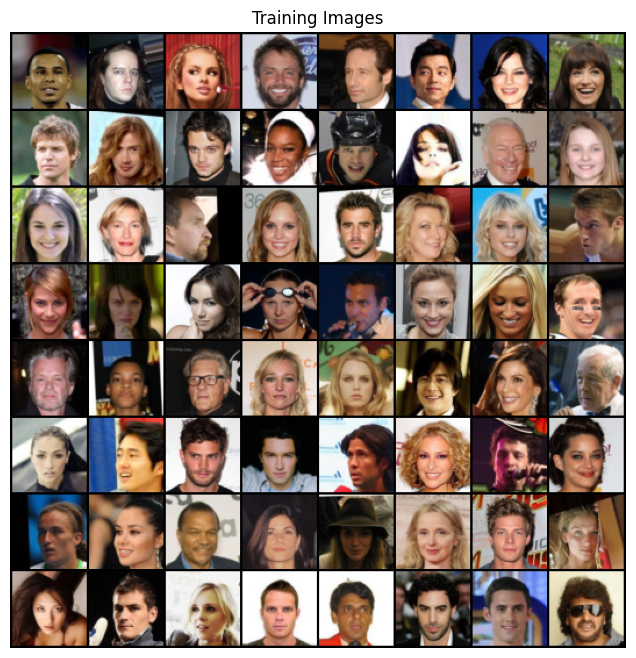

In [14]:
#Showing a batch of Real examles from training Dataset
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(type(real_batch))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [15]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #input 100 * 1024 * 3

            nn.ConvTranspose2d(100, 1024,kernel_size= 4, stride= 2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            #output  3 * 3

            #input
            nn.ConvTranspose2d(1024, 512, kernel_size= 4, stride=2,padding= 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #output  7*7

            #input
            nn.ConvTranspose2d(512, 256, kernel_size= 4, stride=2,padding= 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #output  14 * 14

            # input
            nn.ConvTranspose2d(256, 128, kernel_size= 4, stride=2,padding= 1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # output  28*28

            nn.ConvTranspose2d(128, 64, kernel_size= 4, stride=2,padding= 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size= 4, stride=2,padding= 1, bias=False),
            nn.Tanh()
            )

    def forward(self, input):
        return self.main(input)

In [16]:
class Critic(nn.Module):
    def __init__(self) -> None:
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64,  kernel_size= 4, stride=2,padding= 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2,  kernel_size= 4, stride=2,padding= 1, bias=True),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, kernel_size= 4, stride=2,padding= 1, bias=True),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8,  kernel_size= 4, stride=2,padding= 1, bias=True),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(64 * 8, 1,  kernel_size= 4, stride=1,padding= 0, bias=True)
        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create an instance of generator 
gen_net = Generator().to(device)

if (device.type == 'cuda') and (1 > 1):
    gen_net = nn.DataParallel(gen_net, list(range(1)))

gen_net.apply(weights_init)
print(gen_net)




Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [18]:
# Create the Critic
Critic_net = Critic().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (1 > 1):
    Critic_net = nn.DataParallel(Critic_net, list(range(1)))

Critic_net.apply(weights_init)


# Print the model
print(Critic_net)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
  )
)


In [19]:
# Setup RMS optimizers for both G and D
#Critic_optimizer = optim.RMSprop(Critic_net.parameters(), lr=lr)
#gen_optimizer = optim.RMSprop(gen_net.parameters(), lr=lr)

# Setup Adam optimizers for both G and D if RMS is not good enough
Critic_optimizer = optim.Adam(Critic_net.parameters(), lr=lr, betas = (beta1,.09))
gen_optimizer = optim.Adam(gen_net.parameters(), lr=lr, betas = (beta1,.09))



In [1]:
fake_list = []
gen_losses = []
Critic_losses =[]
# Training the WGAN
for epoch in tqdm(range(EPOCH_NUM)):
    batch_num = 0

    for i, (imgs, _) in enumerate(train_loader):
        batch_num+=1 #for printing our loss results
        imgs = imgs.to(device)
        noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=device)
         # For Loop for Training Critic: max E[critic(real)] - E[critic(fake)]
        for _ in range(critic_iter):
            fake_images = gen_net(noise)
            real_outputs = Critic_net(imgs).reshape(-1)
            fake_outputs = Critic_net(fake_images).reshape(-1)

            Critic_loss =-(torch.mean(real_outputs) - torch.mean(fake_outputs))
            Critic_net.zero_grad()
            Critic_loss.backward(retain_graph=True) #retain_graph because 2 loss function
            Critic_optimizer.step()
              # clip critic weights between -0.01, +0.01
            for p in Critic_net.parameters():
                p.data.clamp_(-weight_clip, weight_clip)


        # Train the generator

        fake_outputs = Critic_net(fake_images).reshape(-1) #rashpe everything?
        gen_loss = -torch.mean(fake_outputs)
        gen_net.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        gen_losses.append(gen_loss)
        Critic_losses.append(Critic_loss)

        # Print the losses of each batch
        print(
                f"Epoch [{epoch}/{EPOCH_NUM}] Batch {batch_num}/{len(train_loader)} \
                  Loss D: {Critic_loss:.4f}, loss G: {gen_loss:.4f}"
            )

    # Saving some generated images every epoch
    save_image(fake_images, "/content/drive/MyDrive/savedfaces\{0:0=6d}.png" .format(epoch+1), nrow=5, normalize=True)



NameError: name 'torch' is not defined

In [ ]:
g = [i.tolist() for i in gen_losses]
c = [i.tolist() for i in Critic_losses]

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Critic Loss During Training")
plt.plot(g.cpu(),label="G")
plt.plot(c.cpu(),label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Saving the models to use it in GUI
torch.save(Critic_net.state_dict(), "M:\\UNISI\\NN\\GANs-project-\\WGAN2\\Critic5epoch.pt")
torch.save(gen_net.state_dict(), "M:\\UNISI\\NN\\GANs-project-\\WGAN2\\gen5epoch.pt")
